In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=bf159f1d22f7e5a8352b28c44d8ddfe02fcc58124ea3fe980f24417a7c9531a8
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, FloatType, IntegerType
from pyspark.sql.functions import col, length, round, sum, avg, max, min, stddev, count, countDistinct, when
import pandas as pd
import matplotlib.pylab as plt
import re

In [3]:
# Initialize SparkContext and SparkSession
conf = SparkConf().setMaster("local").setAppName("Spark")
sc = SparkContext(conf=conf)
spark = SparkSession.builder.appName("Spark").getOrCreate()

In [4]:
# download the datasetss
from urllib.request import urlretrieve
urlretrieve('https://drive.google.com/uc?export=download&id=1JfhqO1qDK963RLnEzNrhjMbiqbYtld-U',
            'yelp_review.csv')
urlretrieve('https://drive.google.com/uc?export=download&id=1_UdUBOzbMqR5Th83iUAxe7mCAwd0zq1U',
            'urban_wanderings.txt')
urlretrieve('https://drive.google.com/uc?export=download&id=1aasyVp2_LnPhop78v6PVoV2nvFfD8hXm',
            'stop_words.txt')
urlretrieve('https://drive.google.com/uc?export=download&id=1dE5B915DkZqEwIgYXBoJMRJPrsmitFKM',
            'yelp_review_new.csv')

('yelp_review_new.csv', <http.client.HTTPMessage at 0x7fa246d05180>)

In [5]:
# Spark Transformation: map, flatMap, filter, distinct
numbers = [1, 2, 3, 4, 5, 6, 7]
numbers = sc.parallelize(numbers)

print(numbers.map(lambda x: x**2).collect())

texts = ["Jaime, Lannister", "Tyrion, Lannister", "Cersei, Lannister",
         "Robb, Stark", "Arya, Stark", "Sansa, Stark"]
texts = sc.parallelize(texts)
print(texts.map(lambda line: line.upper()).collect())
print(texts.map(lambda line: line.lower()).collect())
print(texts.flatMap(lambda line: line.split(', ')).collect())
print(texts.filter(lambda line: "Stark" in line).collect())

data = sc.parallelize([1, 1, 3, -5, 'data', 'Data'])
print(data.distinct().collect())
list_data = sc.parallelize(['1', '1', '3', '-5', 'data', 'Data'])
lower_data = list_data.map(lambda line: line.lower())
print(lower_data.distinct().collect())

[1, 4, 9, 16, 25, 36, 49]
['JAIME, LANNISTER', 'TYRION, LANNISTER', 'CERSEI, LANNISTER', 'ROBB, STARK', 'ARYA, STARK', 'SANSA, STARK']
['jaime, lannister', 'tyrion, lannister', 'cersei, lannister', 'robb, stark', 'arya, stark', 'sansa, stark']
['Jaime', 'Lannister', 'Tyrion', 'Lannister', 'Cersei', 'Lannister', 'Robb', 'Stark', 'Arya', 'Stark', 'Sansa', 'Stark']
['Robb, Stark', 'Arya, Stark', 'Sansa, Stark']
[1, 3, -5, 'data', 'Data']
['1', '3', '-5', 'data']


In [6]:
# Spark Transformation: groupByKey, reduceByKey, sortBy
grades = [("s1", 100), ("s1", 96), ("s2", 93), ("s3", 75), ("s1", 60)]
grades = sc.parallelize(grades)
grouped_grades = grades.groupByKey().collect()

grouped_grades_list = [(key, list(values)) for key, values in grouped_grades]
for key, values in grouped_grades_list:
    print(key, values)

grades = [("s1", 100), ("s1", 96), ("s2", 93), ("s3", 75), ("s1", 60)]
grades = sc.parallelize(grades)
print(grades.reduceByKey(lambda v1,v2: v1+v2).collect())
reduced_grades = grades.reduceByKey(lambda v1,v2: v1+v2).collect()
for key, values in reduced_grades:
  print(key, values)

## Sort RDD by values in the ascending order
print(grades.sortBy(lambda pair: pair[1]).collect())

## Sort RDD by values in the descending order
print(grades.sortBy(lambda pair: -pair[1]).collect())

## Sort RDD by keys
print(grades.sortBy(lambda pair: pair[0]).collect())
print(grades.sortByKey(ascending=True).collect())
print(grades.sortByKey(ascending=False).collect())

s1 [100, 96, 60]
s2 [93]
s3 [75]
[('s1', 256), ('s2', 93), ('s3', 75)]
s1 256
s2 93
s3 75
[('s1', 60), ('s3', 75), ('s2', 93), ('s1', 96), ('s1', 100)]
[('s1', 100), ('s1', 96), ('s2', 93), ('s3', 75), ('s1', 60)]
[('s1', 100), ('s1', 96), ('s1', 60), ('s2', 93), ('s3', 75)]
[('s1', 100), ('s1', 96), ('s1', 60), ('s2', 93), ('s3', 75)]
[('s3', 75), ('s2', 93), ('s1', 100), ('s1', 96), ('s1', 60)]


In [7]:
# Spark Transformation: subtract, intersection, union
data1 = sc.parallelize(['Stark', 'Lannister', 'Targaryen'])
data2 = sc.parallelize(['Baratheon', 'Martell', 'Lannister'])
print(data1.subtract(data2).collect())
print(data2.subtract(data1).collect())
print(data1.intersection(data2).collect())
print(data1.union(data2).collect())
print(set(data1.union(data2).collect()))

['Stark', 'Targaryen']
['Martell', 'Baratheon']
['Lannister']
['Stark', 'Lannister', 'Targaryen', 'Baratheon', 'Martell', 'Lannister']
{'Lannister', 'Targaryen', 'Martell', 'Stark', 'Baratheon'}


In [8]:
data = [('Robb',19),('Sansa',17),('Arya',14),('Bran',12),('Rickon',8)]
rdd = sc.parallelize(data)
people = spark.createDataFrame(rdd, ["Name", "Age"])
people.show()
print(people.take(4))
print(people.head(3))

+------+---+
|  Name|Age|
+------+---+
|  Robb| 19|
| Sansa| 17|
|  Arya| 14|
|  Bran| 12|
|Rickon|  8|
+------+---+

[Row(Name='Robb', Age=19), Row(Name='Sansa', Age=17), Row(Name='Arya', Age=14), Row(Name='Bran', Age=12)]
[Row(Name='Robb', Age=19), Row(Name='Sansa', Age=17), Row(Name='Arya', Age=14)]


In [9]:
# Spark SQL: createDataFrame, read csv, withColumn, select, drop, dropDuplicates, fillna, sort, groupBy, agg, createOrReplaceTempView
pdf = pd.read_csv('yelp_review.csv')
print("Displaying top 20 rows of yelp reviews")
print(pdf.head(20))

# Converting pandas dataframe to Spark dataframe
df = spark.createDataFrame(pdf)
print()
print("Displaying top 5 rows of yelp reviews")
df.show(n=5)

print("Running SQL Query on a Spark DataFrame Temporary View")
df.createOrReplaceTempView("reviews_df")
spark.sql(
"""
    SELECT *
    FROM reviews_df
    WHERE review_count > 500 AND stars > 4
    ORDER BY review_count DESC, stars DESC
"""
).show(n=20)

# Schema definition
df = spark.read.csv('yelp_review.csv', header=True, inferSchema=True)
print('Inferred Schema of the DataFrame:')
df.printSchema()
schema = StructType([
    StructField('name', StringType(), True),
    StructField('postal_code', StringType(), True),
    StructField('stars', FloatType(), True),
    StructField('review_count', IntegerType(), True),
    StructField('is_open', IntegerType(), True)])
reviews = spark.read.csv('yelp_review.csv', header=True, schema=schema)
print('Specified Schema of the DataFrame:')
reviews.printSchema()

Displaying top 20 rows of yelp reviews
                           name  postal_code  stars  review_count  is_open
0           Cold Stone Creamery      85032.0    3.5          37.0        1
1   House of Blunt's Smoke Shop      85008.0    5.0           5.0        0
2            Copper Square Cafe      85004.0    NaN           3.0        0
3                Wang’s Express      85032.0    3.5         108.0        0
4                       Safeway      85051.0    3.0          22.0        0
5                Carl's Jr 7091      85022.0    2.0          29.0        1
6          Carniceria Mi Casita      85015.0    3.5           3.0        1
7              The Dipping Well      85041.0    4.0           4.0        0
8             Abby's Grill-Cafe      85022.0    3.0           5.0        0
9             Taste Of Honduras      85021.0    4.0          15.0        1
10              AZ Deli Company      85012.0    3.5           4.0        1
11                       Stella      85016.0    3.5          

In [10]:
# Summary statistics of the DataFrame: count, mean, stddev, min, max
print('Summary statistics of the DataFrame:')
reviews.describe(['stars', 'review_count', 'is_open']).show()

# Handling Duplicates
print('Number of rows before dropping duplicates:', reviews.count())
reviews.dropDuplicates().count()
print('Number of rows after dropping duplicates:', reviews.dropDuplicates().count())

# Imputation of NULL values with -1
print('First 5 rows of the DataFrame before filling the missing values:')
reviews.show(n=5)
print('First 5 rows of the DataFrame after filling the missing values:')
reviews.fillna(value= -1).show(n=5)

# Sorting by given columns in certain orders
print()
print('First 5 rows of sorting the DataFrame by postal_code (dsc) and stars (asc)')
reviews.sort('postal_code', 'stars', ascending=[False, True]).show(n=20)

Summary statistics of the DataFrame:
+-------+------------------+------------------+------------------+
|summary|             stars|      review_count|           is_open|
+-------+------------------+------------------+------------------+
|  count|              1547|              1538|              1635|
|   mean|3.4450549450549453| 93.65474642392718| 0.692354740061162|
| stddev|0.8958830915899021|191.52779860501914|0.4616600575330277|
|    min|               1.0|                 3|                 0|
|    max|               5.0|              3515|                 1|
+-------+------------------+------------------+------------------+

Number of rows before dropping duplicates: 1635
Number of rows after dropping duplicates: 1500
First 5 rows of the DataFrame before filling the missing values:
+--------------------+-----------+-----+------------+-------+
|                name|postal_code|stars|review_count|is_open|
+--------------------+-----------+-----+------------+-------+
| Cold Stone 

In [11]:
## drop duplicates, fill missing values, sort, filter
reviews = reviews.dropDuplicates().fillna(value=-1)\
    .sort('postal_code', 'stars', ascending=[False, True])
reviews.show(n=5)

# filter transformation on a dataframe
print('Businesses with a star rating over 4.0:')
reviews.filter(reviews['stars'] > 4.0).show(n=5)
print('Businesses with a star rating below 3.0 AND over 100 reviews:')
reviews.filter((reviews['stars'] < 3.0) & (reviews['review_count'] > 100)).show(n=5)
print('Businesses with a star rating over 4.5 OR located in 85281:')
reviews.filter((reviews['stars'] > 4.5) | (reviews['postal_code'] == '85281')).show(n=5)
print('Businesses not located in 85310, having more than 200 reviews, sorted by review count in ascending and star rating in descending order')
review_filtered = reviews.filter((reviews['postal_code'] != '85310') & (reviews['review_count'] > 200))
review_filtered = review_filtered.sort('review_count', 'stars', ascending=[True,False])
review_filtered.show(20)

+--------------------+-----------+-----+------------+-------+
|                name|postal_code|stars|review_count|is_open|
+--------------------+-----------+-----+------------+-------+
|         Greers Farm|      85355|  3.5|           3|      0|
|Charlie Mae’s Sou...|      85339| -1.0|          39|      1|
|          McDonald's|      85339| -1.0|          -1|      1|
|Federico's Mexica...|      85339|  3.0|          42|      1|
|      Firehouse Subs|      85339|  3.0|          44|      1|
+--------------------+-----------+-----+------------+-------+
only showing top 5 rows

Businesses with a star rating over 4.0:
+--------------------+-----------+-----+------------+-------+
|                name|postal_code|stars|review_count|is_open|
+--------------------+-----------+-----+------------+-------+
|          Jacked Ice|      85283|  5.0|          14|      1|
|Jesse James Body ...|      85250|  5.0|          11|      1|
|       Yogurt Garden|      85086|  4.5|           9|      0|
|    

In [12]:
# Grouping by specific columns and calculating group statistics
print('The average and standard deviation of star ratings by postal code:')
reviews.groupby('postal_code').agg(
    avg('stars').alias('mean_stars'),
    stddev('stars').alias('std_stars')
).show(n=5)

print('The average and standard deviation of star ratings (rounded) by postal code:')
reviews.groupby('postal_code').agg(
    round(avg('stars'), 2).alias('mean_stars'),
    round(stddev('stars'), 2).alias('std_stars')
).show(n=5)

The average and standard deviation of star ratings by postal code:
+-----------+------------------+------------------+
|postal_code|        mean_stars|         std_stars|
+-----------+------------------+------------------+
|      85022| 3.044642857142857|1.2801874355460103|
|      85339|               1.0| 2.309401076758503|
|      85254|               3.5|              NULL|
|      85032| 3.186868686868687|1.2404448234935448|
|      85003|3.0444444444444443|1.6645441029624515|
+-----------+------------------+------------------+
only showing top 5 rows

The average and standard deviation of star ratings (rounded) by postal code:
+-----------+----------+---------+
|postal_code|mean_stars|std_stars|
+-----------+----------+---------+
|      85022|      3.04|     1.28|
|      85339|       1.0|     2.31|
|      85254|       3.5|     NULL|
|      85032|      3.19|     1.24|
|      85003|      3.04|     1.66|
+-----------+----------+---------+
only showing top 5 rows



In [13]:
# Other aggregate functions
print('The maximum review count and lowest star rating by postal code:')
reviews.groupby('postal_code').agg(
    max('review_count').alias('max_review_count'),
    min('stars').alias('min_stars')
).show(n=5)

print('The average review count by postal code and open status:')
reviews.groupby(['postal_code', 'is_open']).agg(
    avg('review_count').alias('mean_review_count'),
).show(n=20)

The maximum review count and lowest star rating by postal code:
+-----------+----------------+---------+
|postal_code|max_review_count|min_stars|
+-----------+----------------+---------+
|      85022|             545|     -1.0|
|      85339|              44|     -1.0|
|      85032|             424|     -1.0|
|      85254|              76|      3.5|
|      85003|            2164|     -1.0|
+-----------+----------------+---------+
only showing top 5 rows

The average review count by postal code and open status:
+-----------+-------+------------------+
|postal_code|is_open| mean_review_count|
+-----------+-------+------------------+
|      85086|      1|             109.0|
|      85304|      1|              10.0|
|      85014|      1|209.63333333333333|
|      85042|      1| 33.38095238095238|
|      85028|      1|109.53846153846153|
|      85021|      1|              54.1|
|      85016|      0| 63.91428571428571|
|      85335|      1|              24.0|
|      85033|      0|             

In [14]:
# Aggregate function Examples
print("Average of reviews, and number of businesses of each group based on postal code and open stuts")
reviews_grouped = reviews.groupby(['postal_code', 'is_open']).agg(
    round(avg('review_count'), 1).alias('mean_review_count'),
    count('name').alias('num_businesses')
)
reviews_grouped.show(20)

print("Average of stars and review count of each group based on postal code")
reviews_grouped = reviews.groupby('postal_code').agg(
    round(avg('stars'), 2).alias('mean_stars'),
    round(avg('review_count'), 2).alias('mean_review_count')
)
reviews_grouped.show(n=5)

# Join operation
print("All columns displayed along with the aggregation")
reviews_joined = reviews.join(reviews_grouped, on='postal_code', how='inner')
reviews_joined.show(n=5)

Average of reviews, and number of businesses of each group based on postal code and open stuts
+-----------+-------+-----------------+--------------+
|postal_code|is_open|mean_review_count|num_businesses|
+-----------+-------+-----------------+--------------+
|      85086|      1|            109.0|             3|
|      85304|      1|             10.0|             1|
|      85014|      1|            209.6|            30|
|      85042|      1|             33.4|            21|
|      85028|      1|            109.5|            13|
|      85021|      1|             54.1|            20|
|      85016|      0|             63.9|            35|
|      85335|      1|             24.0|             1|
|      85033|      0|              5.0|             2|
|      85048|      0|             26.7|            10|
|      85044|      0|             31.6|            12|
|      85253|      1|             15.0|             1|
|      85254|      1|             76.0|             1|
|      85007|      1|    

In [15]:
# creating a new column using withColumn function
reviews_joined = reviews_joined.withColumn(
    'diff_stars',
    col('stars') - col('mean_stars')
)

# Sorting based on the created column
print("Displaying reviews sorted by difference in stars from average, and review count in descending order")
reviews_joined.select(['name', 'postal_code', 'diff_stars', 'review_count'])\
    .sort('diff_stars', 'review_count', ascending=[False, False]).show(n=5)

# Creating another column showcasing comparison
print("")
print("Displaying along with the stars comparison column")
reviews_joined.withColumn(
    'better_than_peers',
    when(col('diff_stars') > 0.5, 'better').
    when(col('diff_stars') < -0.5, 'worse').
    otherwise('similar')
).show(n=10)

Displaying reviews sorted by difference in stars from average, and review count in descending order
+-------------------+-----------+----------+------------+
|               name|postal_code|diff_stars|review_count|
+-------------------+-----------+----------+------------+
|         Jacked Ice|      85283|       3.0|          14|
|Watertyme Westridge|      85033|      2.64|           4|
|       Encinas Meat|      85033|      2.64|           3|
|   Faye's Farmstand|      85043|       2.2|           5|
|     Paint-A-Holics|      85028|      2.15|          20|
+-------------------+-----------+----------+------------+
only showing top 5 rows


Displaying along with the stars comparison column
+-----------+--------------------+-----+------------+-------+----------+-----------------+----------+-----------------+
|postal_code|                name|stars|review_count|is_open|mean_stars|mean_review_count|diff_stars|better_than_peers|
+-----------+--------------------+-----+------------+-------+-

In [16]:
# Read and process external files
stop_words_file = open('stop_words.txt')
stop_words = stop_words_file.read().split()
stop_words_file.close()
urban_wanderings = sc.textFile('urban_wanderings.txt')
words = urban_wanderings.flatMap(lambda line: line.split())
words_cleaned = words.map(lambda word: word.lower()).filter(lambda x: x not in stop_words)
word_counts = words_cleaned.map(lambda word: (word, 1)).reduceByKey(lambda count1, count2: count1 + count2)
word_counts_sorted = word_counts.sortBy(lambda x: -x[1])
top_ten_words = word_counts_sorted.take(10)
for word_occurrence in top_ten_words:
    print(word_occurrence[0] + ':\t' + str(word_occurrence[1]))

city:	14
city,:	14
sense:	14
found:	11
amidst:	10
help:	10
way:	9
place:	8
made:	8
bustling:	7


('city', 'city,', 'sense', 'found', 'amidst', 'help', 'way', 'place', 'made', 'bustling', 'streets,', 'filled', 'heart', 'hustle', 'bustle', 'feel', 'still', 'life.', 'chaos', 'life,')
(14, 14, 14, 11, 10, 10, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 6, 5, 5, 5)


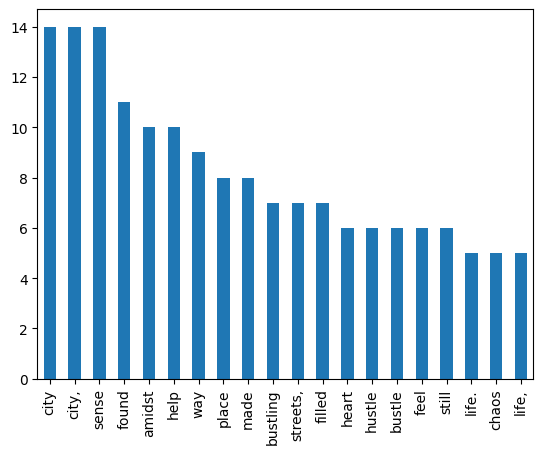

In [23]:
# Plot top 20 word occurences from the list
top_20_words = word_counts_sorted.take(20)

words, counts = zip(*top_20_words)
print(words)
print(counts)
pd.Series(counts, index=words).plot(kind='bar')
plt.show()

In [27]:
# Replacing non-alphanumeric non-space characters in the words with empty string using RegEx
wordcounts = (words_cleaned.flatMap(lambda word: word.split())
                       .map(lambda word: re.sub(r'[^\w\s]','',word).lower())
                       .filter(lambda word: len(word) > 0)
                       .filter(lambda word: word not in stop_words)
                       .map(lambda word: (word, 1))
                       .reduceByKey(lambda x,y: x+y)
                       .takeOrdered(20, lambda w: -w[1]))
wordcounts

[('city', 29),
 ('life', 14),
 ('sense', 14),
 ('found', 12),
 ('streets', 11),
 ('made', 10),
 ('amidst', 10),
 ('help', 10),
 ('way', 9),
 ('place', 8),
 ('chaos', 8),
 ('bustling', 7),
 ('filled', 7),
 ('heart', 6),
 ('hustle', 6),
 ('bustle', 6),
 ('feel', 6),
 ('still', 6),
 ('home', 6),
 ('dreams', 5)]

('city', 'life', 'sense', 'found', 'streets', 'made', 'amidst', 'help', 'way', 'place', 'chaos', 'bustling', 'filled', 'heart', 'hustle', 'bustle', 'feel', 'still', 'home', 'dreams')
(29, 14, 14, 12, 11, 10, 10, 10, 9, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5)


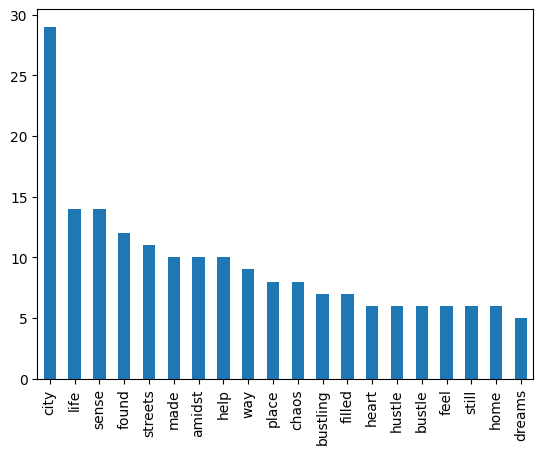

In [26]:
words, counts = zip(*wordcounts)
print(words)
print(counts)
pd.Series(counts, index=words).plot(kind='bar')
plt.show()

In [28]:
# Define functions and variables used in multiple sections
def line_parser(line):
    fields = line.split(',')
    postal_code = fields[1]
    stars = fields[2]
    return (postal_code, stars)

In [29]:
# Transformations using Map Reduce
lines = sc.textFile("yelp_review_new.csv")
header = lines.first()
lines = lines.filter(lambda line: line != header)
rdd = lines.map(line_parser)
print('First 5 pairs: ')
for pair in rdd.take(5):
    print(pair[0] + ':', pair[1])
print()
print("Performing the following transformations:")
print("Filtering out missing values, Converting star ratings to float, Creating postal code: (stars, 1) pairs, Getting total str ratings by postal code")
rdd = lines.map(line_parser)
rdd = rdd.filter(lambda line: (len(line[0]) != 0) and (len(line[1]) != 0))
rdd = rdd.map(lambda line: (line[0], float(line[1])))
rdd = rdd.map(lambda line: (line[0], (line[1], 1)))
totals_by_code = rdd.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))
# Can be performaed in a single line
# totals_by_code = lines.map(line_parser).filter(lambda line: (len(line[0]) != 0) and (len(line[1]) != 0)).map(lambda line: (line[0], float(line[1]))).map(lambda line: (line[0], (line[1], 1))).reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

print()
print('First 5 reduced pairs: ')
for pair in totals_by_code.take(5):
    print(pair[0] + ':', pair[1])
averages_by_code = totals_by_code.map(lambda x: (x[0], x[1][0] / x[1][1]))
averages_by_code_sorted = averages_by_code.sortBy(lambda x: (-x[1], x[0]))
print()
print("Displaying average star ratings by postal code, and sorting the results")
for result in averages_by_code_sorted.take(5):
    print(result[0] + ':', result[1])

First 5 pairs: 
85004: 4
85015: 4
85016: 3.5
85040: 1.5
85016: 3.5

Performing the following transformations:
Filtering out missing values, Converting star ratings to float, Creating postal code: (stars, 1) pairs, Getting total str ratings by postal code

First 5 reduced pairs: 
85004: (260.5, 74)
85015: (121.0, 35)
85016: (384.0, 107)
85040: (116.0, 35)
85053: (90.0, 26)

Displaying average star ratings by postal code, and sorting the results
85250: 5.0
85283: 5.0
85005: 4.5
85001: 4.3
85045: 4.0


In [30]:
# Stop SparkContext
sc.stop()